In [1]:

import pandas as pd
import matplotlib.pylab as plt
import warnings
from spacepy import pycdf
from spacepy.time import Ticktock
import os
import numpy as np
import pandas as pd
from spacepy import pycdf
from spacepy.time import Ticktock
# 完全忽略PerformanceWarning
warnings.filterwarnings('ignore', category=pd.errors.PerformanceWarning)

d:\anaconda3\envs\tensorflow\lib\site-packages\spacepy\time.py:2341: UserWarning: Leapseconds may be out of date. Use spacepy.toolbox.update(leapsecs=True)
  warnings.warn('Leapseconds may be out of date.'


In [3]:


def process_cdf_file(file_path):
    with pycdf.CDF(file_path) as cdf:
        if 'PA_Midpoint' not in cdf:
            print(f"在文件 {file_path} 中未找到 'FPDU_ENERGY_LABL' 变量，跳过该文件。")
            return pd.DataFrame()  # 返回空的 DataFrame
        # 读取时间变量，并将其转换为 datetime 对象
        epoch = cdf['Epoch'][...]
        tt = Ticktock(epoch, 'CDFepoch')
        datetime_array = np.array(tt.UTC)

        # 读取能量标签
        FPDU_ENERGY_LABL = cdf['FPDU_Energy'][...]  # 形状：[能量]
        #将FPDU_ENERGY_LABL保留三位小数
        FPDU_ENERGY_LABL = np.round(FPDU_ENERGY_LABL, 3)
        FPDU_ENERGY_LABL = np.array(FPDU_ENERGY_LABL).astype(str)  # 转换为字符串数组
        FPDU_ENERGY_LABL = FPDU_ENERGY_LABL.squeeze()
        # 去除前后空格并转换为大写
        FPDU_ENERGY_LABL_clean = np.char.strip(FPDU_ENERGY_LABL)
        FPDU_ENERGY_LABL_upper = np.char.upper(FPDU_ENERGY_LABL_clean)
        

        # 查找包含 'LOW/2' 的能量标签（不区分大小写）
        # target_label = '114'############################################################################################################################################################################
        # contains_target = np.char.find(FPDU_ENERGY_LABL_upper, target_label.upper()) >= 0
        # energy_indices = np.where(contains_target)[0]
        # print(energy_indices)

        target_labels = ['0.055']
        for target_label in target_labels:
            contains_target = np.char.find(FPDU_ENERGY_LABL_upper, target_label.upper()) >= 0
            energy_indices = np.where(contains_target)[0]
            if len(energy_indices) > 0:
                energy_kev=0.055
                break

        if len(energy_indices) == 0:
            print(f"在文件 {file_path} 中未找到包含 '{target_label}' 的能量标签")
            return pd.DataFrame()  # 返回空的 DataFrame 
        else:
            energy_index = energy_indices[0]  # 获取第一个匹配的索引

        # 读取通量数据和相关变量
        FPDU_corr = cdf['FPDU_OmniFlux'][...]  # 形状：[时间，俯仰角，能量]
        I = cdf['I'][...]
        L = cdf['L'][...]
        Position = cdf['Position'][...]
        MLT = cdf['MLT'][...]
        FPDU_ERROR = cdf['FPDU_Error'][...]

    # 获取数据的维度
    

    # 提取并展开数据，以匹配总记录数
    time_array = datetime_array
    flux_array = FPDU_corr[:, energy_index]
 
   
    I_array = I
    L_array = L
  
    MLT_array = MLT
    # MLAT_array = MLAT[time_flat]
    Position_array = Position
    X_array = Position_array[:, 0]
    Y_array = Position_array[:, 1]
    Z_array = Position_array[:, 2]
    Error = FPDU_ERROR[:, energy_index,1:5].sum(axis=1)

    data = {
        'Time': time_array,
        'Flux': flux_array,
        
        'I': I_array,
        'L': L_array,
       
        # 'L_star_PitchAngle': L_star_PitchAngle_array,
        'MLT': MLT_array,
        'X': X_array,
        'Y': Y_array,
        'Z': Z_array,
        'Flux_Error': Error,
        'energy_kev': energy_kev,
    }

    
    # 创建 DataFrame
    df = pd.DataFrame(data)
    # df = df[df['L'] >= 2]
    df = df[df['Flux'] >0]
    # df = df[df['Flux_Error'] <95]
    
    
    
    df = df.sample(frac=0.1, replace=False, random_state=1565)
    return df


folder_paths = [ '../RB']  # 请替换为您的文件夹路径
# 存储所有 CDF 文件的路径
cdf_files = []

# 遍历所有文件夹，获取其中的 CDF 文件
for folder_path in folder_paths:
    cdf_files.extend([os.path.join(folder_path, f) for f in os.listdir(folder_path) if f.endswith('.cdf')])
print(len(cdf_files))
df_list = []
youxiao=0
wuxiao=0
for file_path in cdf_files:
    print(f"Processing file: {file_path}")
    df = process_cdf_file(file_path)
    if not df.empty:
        df_list.append(df)
        youxiao+=1
    else:
        wuxiao+=1
        print(f"跳过文件 {file_path}，因为不包含目标能量标签。")
if df_list:
    combined_df = pd.concat(df_list, ignore_index=True)
    # 可选：查看拼接后的 DataFrame 的前几行
    print(combined_df.head())
else:
    print("未找到包含目标能量标签的数据。")
print(youxiao)
print(wuxiao)



2098
Processing file: ../RB\rbsp-b-rbspice_lev-3-pap_tofxeh_20121114_v1.2.4-05.cdf
Processing file: ../RB\rbsp-b-rbspice_lev-3-pap_tofxeh_20121115_v1.2.4-01.cdf
Processing file: ../RB\rbsp-b-rbspice_lev-3-pap_tofxeh_20121116_v1.2.4-01.cdf
Processing file: ../RB\rbsp-b-rbspice_lev-3-pap_tofxeh_20121117_v1.2.4-01.cdf
Processing file: ../RB\rbsp-b-rbspice_lev-3-pap_tofxeh_20121118_v1.2.4-01.cdf
Processing file: ../RB\rbsp-b-rbspice_lev-3-pap_tofxeh_20121119_v1.2.4-01.cdf
Processing file: ../RB\rbsp-b-rbspice_lev-3-pap_tofxeh_20121120_v1.2.4-01.cdf
Processing file: ../RB\rbsp-b-rbspice_lev-3-pap_tofxeh_20121121_v1.2.4-01.cdf
Processing file: ../RB\rbsp-b-rbspice_lev-3-pap_tofxeh_20121122_v1.2.4-02.cdf
Processing file: ../RB\rbsp-b-rbspice_lev-3-pap_tofxeh_20121123_v1.2.4-01.cdf
Processing file: ../RB\rbsp-b-rbspice_lev-3-pap_tofxeh_20121124_v1.2.4-02.cdf
Processing file: ../RB\rbsp-b-rbspice_lev-3-pap_tofxeh_20121125_v1.2.4-02.cdf
Processing file: ../RB\rbsp-b-rbspice_lev-3-pap_tofxeh_2012

In [4]:
#查看combined_df中有多少nan
print(combined_df.isna().sum())
import numpy as np  
print(np.cos(np.pi))

Time          0
Flux          0
I             0
L             0
MLT           0
X             0
Y             0
Z             0
Flux_Error    0
energy_kev    0
dtype: int64
-1.0


(array([1.0000e+00, 4.0000e+00, 1.0000e+00, 6.0000e+00, 4.0000e+00,
        5.0000e+00, 3.0000e+00, 5.0000e+00, 1.8000e+01, 2.1000e+01,
        2.8000e+01, 5.8000e+01, 7.0000e+01, 6.3000e+01, 7.1000e+01,
        9.3000e+01, 1.0400e+02, 1.6900e+02, 2.5100e+02, 3.3100e+02,
        4.1500e+02, 5.5800e+02, 7.0100e+02, 8.8500e+02, 1.1500e+03,
        1.3260e+03, 1.6060e+03, 1.9520e+03, 2.1790e+03, 2.4990e+03,
        2.8700e+03, 3.2420e+03, 3.6670e+03, 4.1720e+03, 4.7230e+03,
        5.4770e+03, 6.1580e+03, 7.1150e+03, 7.8460e+03, 8.7940e+03,
        9.8410e+03, 1.0968e+04, 1.1764e+04, 1.2575e+04, 1.3168e+04,
        1.3127e+04, 1.3600e+04, 1.3357e+04, 1.2994e+04, 1.2445e+04,
        1.2259e+04, 1.2181e+04, 1.2064e+04, 1.1999e+04, 1.2078e+04,
        1.2445e+04, 1.3096e+04, 1.3794e+04, 1.4074e+04, 1.5362e+04,
        1.6124e+04, 1.7227e+04, 2.0008e+04, 2.1406e+04, 2.4424e+04,
        2.6722e+04, 3.0257e+04, 3.3343e+04, 3.7138e+04, 4.1041e+04,
        4.4274e+04, 4.8805e+04, 5.1078e+04, 5.61

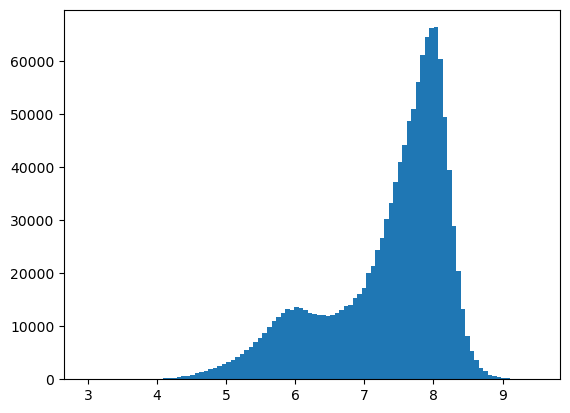

In [7]:
#查看df['Flux']的分布   
plt.hist(np.log10(combined_df['Flux']+1), bins=100)

                     BZGSM     TEMP  PDYN  Kp  Dst  F107    AE     AL     AU
datetime                                                                    
2010-01-01 00:00:00    1.6  36035.0  0.51   0    5  72.7     4     -2      2
2010-01-01 01:00:00    1.6  30846.0  0.52   0    4  72.7     4     -2      1
2010-01-01 02:00:00    1.2  27445.0  0.52   0    4  72.7     4     -2      2
2010-01-01 03:00:00    1.0  25799.0  0.60   0    2  72.7     3     -2      2
2010-01-01 04:00:00    0.3  25220.0  0.52   0    0  72.7     3     -1      2
...                    ...      ...   ...  ..  ...   ...   ...    ...    ...
2020-01-01 19:00:00   -0.3  18136.0  2.30  10    2  69.4  9999  99999  99999
2020-01-01 20:00:00   -0.2  16553.0  2.31  10    5  69.4  9999  99999  99999
2020-01-01 21:00:00    0.4  17917.0  2.37   7    7  69.4  9999  99999  99999
2020-01-01 22:00:00    1.2  18613.0  2.14   7    6  69.4  9999  99999  99999
2020-01-01 23:00:00    1.1  19557.0  1.89   7    5  69.4  9999  99999  99999

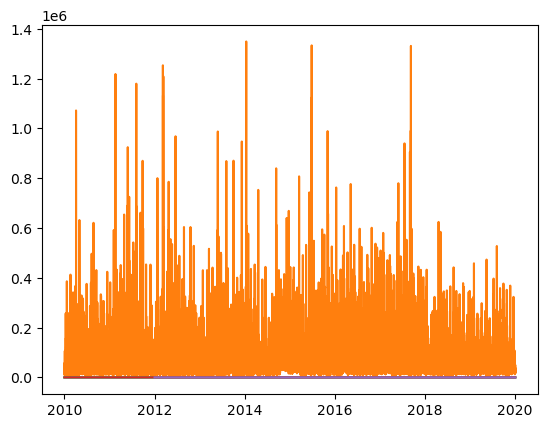

In [9]:
from scipy import stats
import pandas as pd 
import matplotlib.pyplot as plt
import numpy as np

TQ=pd.read_csv('../空间天气参数/TQ.txt',sep='\s+',header=None)
TQ.columns=['year','day','hour','BXGSM','BYGSM','BZGSM','TEMP','DEN','PDYN','Kp','Dst','F107','AE','AL','AU']
TQ['datetime'] = pd.to_datetime(TQ['year'].astype(str) + TQ['day'].astype(str).str.zfill(3) + TQ['hour'].astype(str).str.zfill(2), format='%Y%j%H')
TQ=TQ.drop(['year','day','hour'],axis=1)
TQ = TQ.sort_values(by='datetime')
TQ.set_index('datetime', inplace=True)

#删除TQ中的BXGSM列
TQ=TQ.drop(['BXGSM'],axis=1)
TQ=TQ.drop(['BYGSM'],axis=1)
TQ=TQ.drop(['DEN'],axis=1)

print(TQ)

z_scores = np.abs(stats.zscore(TQ['BZGSM']))
threshold = 3  # 设置Z-score阈值
TQ['BZGSM_IS1'] = np.where(z_scores >= threshold, 0, 1)
TQ['BZGSM_no_outliers'] = TQ['BZGSM'].where(z_scores < threshold, np.nan)  # 将异常值替换为NaN

# 在原位置插值
TQ['BZGSM'] = TQ['BZGSM_no_outliers'].interpolate(method='time')
# 删除临时列
TQ = TQ.drop(columns=['BZGSM_no_outliers'])
plt.plot(TQ.index, TQ['BZGSM'])

z_scores = np.abs(stats.zscore(TQ['TEMP']))
threshold = 3  # 设置Z-score阈值
TQ['TEMP_IS1'] = np.where(z_scores >= threshold, 0, 1)
TQ['TEMP_no_outliers'] = TQ['TEMP'].where(z_scores < threshold, np.nan)  # 将异常值替换为NaN

# 在原位置插值
TQ['TEMP'] = TQ['TEMP_no_outliers'].interpolate(method='time')
# 删除临时列
TQ = TQ.drop(columns=['TEMP_no_outliers'])
plt.plot(TQ.index, TQ['TEMP'])


z_scores = np.abs(stats.zscore(TQ['PDYN']))
threshold = 3  # 设置Z-score阈值
TQ['PDYN_IS1'] = np.where(z_scores >= threshold, 0, 1)
TQ['PDYN_no_outliers'] = TQ['PDYN'].where(z_scores < threshold, np.nan)  # 将异常值替换为NaN

# 在原位置插值
TQ['PDYN'] = TQ['PDYN_no_outliers'].interpolate(method='time')
# 删除临时列
TQ = TQ.drop(columns=['PDYN_no_outliers'])
plt.plot(TQ.index, TQ['PDYN'])

z_scores = np.abs(stats.zscore(TQ['F107']))
threshold = 3  # 设置Z-score阈值
TQ['F107_IS1'] = np.where(z_scores >= threshold, 0, 1)
TQ['F107_no_outliers'] = TQ['F107'].where(z_scores < threshold, np.nan)  # 将异常值替换为NaN

# 在原位置插值
TQ['F107'] = TQ['F107_no_outliers'].interpolate(method='time')
# 删除临时列
TQ = TQ.drop(columns=['F107_no_outliers'])
plt.plot(TQ.index, TQ['F107'])

V_H_5=pd.read_csv('../空间天气参数/V_H_5.txt',sep='\s+',header=None)
V_H_5.columns=['year','day','hour','min','VX', 'VY', 'VZ', 'SYMH']
year_str = V_H_5['year'].astype(str)
day_str = V_H_5['day'].astype(str).str.zfill(3)
hour_str = V_H_5['hour'].astype(str).str.zfill(2)
min_str = V_H_5['min'].astype(str).str.zfill(2)

# 合并字符串
datetime_str = year_str + day_str + hour_str + min_str

# 转换为 datetime 对象
V_H_5['datetime'] = pd.to_datetime(datetime_str, format='%Y%j%H%M')
V_H_5=V_H_5.drop(['year','day','hour','min'],axis=1)
V_H_5 = V_H_5.sort_values(by='datetime')
V_H_5.set_index('datetime', inplace=True)

V_H_5=V_H_5.drop(['VY'],axis=1)
V_H_5=V_H_5.drop(['VZ'],axis=1)
print(V_H_5)



z_scores = np.abs(stats.zscore(V_H_5['VX']))
threshold = 3  # 设置Z-score阈值
V_H_5['VX_IS1'] = np.where(z_scores >= threshold, 0, 1)
V_H_5['VX_no_outliers'] = V_H_5['VX'].where(z_scores < threshold, np.nan)  # 将异常值替换为NaN
# 在原位置插值
V_H_5['VX'] = V_H_5['VX_no_outliers'].interpolate(method='time')
# 删除临时列
V_H_5 = V_H_5.drop(columns=['VX_no_outliers'])

plt.plot(V_H_5.index, V_H_5['SYMH'])

#将V_H_5修改为1h的频率
V_H_5=V_H_5.resample('1H').mean()
print(V_H_5)

combined_df['Time'] = pd.to_datetime(combined_df['Time'])
combined_df = combined_df.sort_values('Time')

combined_df = combined_df.reset_index(drop=True)

TQ = TQ.reset_index()
print(TQ)

V_H_5 = V_H_5.reset_index()
print(V_H_5)

In [10]:
combined_df['datetime_hour'] = combined_df['Time'].dt.floor('H')

# 保存原始列名（确保每次循环从原始列开始）
original_TQ_columns = TQ.columns.tolist()
original_V_H_5_columns = V_H_5.columns.tolist()

for i in range(1, 121):
    combined_df[f'datetime_minus_h'] = combined_df['datetime_hour'] - pd.Timedelta(hours=i)
    
    # 每次循环使用原始列名创建临时副本（避免污染原始数据）
    temp_TQ = TQ.rename(columns={col: f"{col}_{i}h" for col in original_TQ_columns if col != 'datetime'})
    temp_V_H_5 = V_H_5.rename(columns={col: f"{col}_{i}h" for col in original_V_H_5_columns if col != 'datetime'})
    
    # 合并临时副本
    combined_df = combined_df.merge(
        temp_TQ,
        left_on=f'datetime_minus_h',
        right_on='datetime',
        how='left'
    ).drop(columns=['datetime'])
    
    combined_df = combined_df.merge(
        temp_V_H_5,
        left_on=f'datetime_minus_h',
        right_on='datetime',
        how='left'
    ).drop(columns=['datetime'])
    print(f"Processed {i} hours")

combined_df.head()

Processed 1 hours
Processed 2 hours
Processed 3 hours
Processed 4 hours
Processed 5 hours
Processed 6 hours
Processed 7 hours
Processed 8 hours
Processed 9 hours
Processed 10 hours
Processed 11 hours
Processed 12 hours
Processed 13 hours
Processed 14 hours
Processed 15 hours
Processed 16 hours
Processed 17 hours
Processed 18 hours
Processed 19 hours
Processed 20 hours
Processed 21 hours
Processed 22 hours
Processed 23 hours
Processed 24 hours
Processed 25 hours
Processed 26 hours
Processed 27 hours
Processed 28 hours
Processed 29 hours
Processed 30 hours
Processed 31 hours
Processed 32 hours
Processed 33 hours
Processed 34 hours
Processed 35 hours
Processed 36 hours
Processed 37 hours
Processed 38 hours
Processed 39 hours
Processed 40 hours
Processed 41 hours
Processed 42 hours
Processed 43 hours
Processed 44 hours
Processed 45 hours
Processed 46 hours
Processed 47 hours
Processed 48 hours
Processed 49 hours
Processed 50 hours
Processed 51 hours
Processed 52 hours
Processed 53 hours
Pr

,Time,Flux,I,L,MLT,X,Y,Z,Flux_Error,energy_kev,...,AE_120h,AL_120h,AU_120h,BZGSM_IS1_120h,TEMP_IS1_120h,PDYN_IS1_120h,F107_IS1_120h,VX_120h,SYMH_120h,VX_IS1_120h
0,2012-11-14 19:03:53.482,73824.762285,3.0,3.471790,2.149820,-0.797881,3.176643,-0.169238,370.710693,0.055,...,18,-10,8,1,1,1,1,-345.408333,2.916667,0.666667
1,2012-11-14 19:04:04.417,71226.411007,3.0,3.477701,2.156243,-0.801992,3.180938,-0.170423,400.000000,0.055,...,18,-10,8,1,1,1,1,-345.408333,2.916667,0.666667
2,2012-11-14 19:07:21.250,66633.728652,3.0,3.582822,2.268179,-0.874209,3.256937,-0.191604,400.000000,0.055,...,18,-10,8,1,1,1,1,-345.408333,2.916667,0.666667
3,2012-11-14 19:07:43.121,76056.642081,3.0,3.594352,2.280249,-0.882026,3.265232,-0.193939,400.000000,0.055,...,18,-10,8,1,1,1,1,-345.408333,2.916667,0.666667
4,2012-11-14 19:07:54.057,121763.428866,3.0,3.600106,2.286284,-0.885920,3.269369,-0.195105,400.000000,0.055,...,18,-10,8,1,1,1,1,-345.408333,2.916667,0.666667


In [ ]:
combined_df.to_hdf('combined_df_train.h5', key='df', mode='w')

In [ ]:

combined_df=pd.read_hdf('combined_df_train.h5', key='df')
combined_df = combined_df[(combined_df['Time'] < '2018-01-01') | (combined_df['Time'] > '2019-01-01')]
combined_df = combined_df[(combined_df['Time'] < '2013-03-10') | (combined_df['Time'] > '2013-04-10')]
combined_df = combined_df[(combined_df['Time'] < '2015-08-25') | (combined_df['Time'] > '2015-09-25')]



In [13]:
print(combined_df)

                           Time           Flux    I         L        MLT  \
0       2012-11-14 19:03:53.482   73824.762285  3.0  3.471790   2.149820   
1       2012-11-14 19:04:04.417   71226.411007  3.0  3.477701   2.156243   
2       2012-11-14 19:07:21.250   66633.728652  3.0  3.582822   2.268179   
3       2012-11-14 19:07:43.121   76056.642081  3.0  3.594352   2.280249   
4       2012-11-14 19:07:54.057  121763.428866  3.0  3.600106   2.286284   
...                         ...            ...  ...       ...        ...   
1058550 2017-12-31 22:01:42.116  287560.188593  3.0  2.418055  12.598842   
1058551 2017-12-31 22:02:14.346  435516.403470  3.0  2.398903  12.634753   
1058552 2017-12-31 22:08:30.394  324969.132666  3.0  2.171160  13.101408   
1058553 2017-12-31 22:10:17.840  207797.977887  3.0  2.104803  13.253291   
1058554 2017-12-31 22:13:52.726  315354.904289  3.0  1.970828  13.587701   

                X         Y         Z  Flux_Error  energy_kev  ... AE_120h  \
0       -

Text(0.5, 0, 'Time')

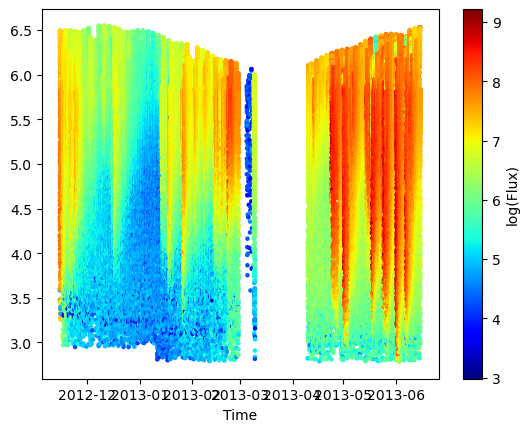

In [14]:
#画横坐标为时间，纵坐标为L,颜色为log(Flux)的图,散点大小为5
fig, ax = plt.subplots()
sc = ax.scatter(combined_df['Time'][0:100000], combined_df['L'][0:100000], c=np.log10(combined_df['Flux'][0:100000]), cmap='jet',s=5)
fig.colorbar(sc, ax=ax, label='log(Flux)')
ax.set_xlabel('Time')

In [15]:
#将combined_df按Time排序
combined_df = combined_df.sort_values('Time')

In [16]:
print(combined_df.columns)

Index(['Time', 'Flux', 'I', 'L', 'MLT', 'X', 'Y', 'Z', 'Flux_Error',
       'energy_kev',
       ...
       'AE_120h', 'AL_120h', 'AU_120h', 'BZGSM_IS1_120h', 'TEMP_IS1_120h',
       'PDYN_IS1_120h', 'F107_IS1_120h', 'VX_120h', 'SYMH_120h',
       'VX_IS1_120h'],
      dtype='object', length=1932)


In [17]:
print(combined_df['Kp_1h'])

0           7
1           7
2           7
3           7
4           7
           ..
1058550    20
1058551    20
1058552    20
1058553    20
1058554    20
Name: Kp_1h, Length: 1022267, dtype: int64


In [18]:
plt.figure(figsize=(12, 6))


plt.show()

<Figure size 1200x600 with 0 Axes>

In [19]:
#查看combined_df['Flux']除去0以外的最小值
print(combined_df[combined_df['Flux']!=0]['Flux'].min())
print(combined_df[combined_df['Flux']!=0]['Flux'].max())

953.8176119530024
3208472415.660568


In [20]:
#检查是否有缺失值
print(combined_df.isnull().sum().tolist())


[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 

In [21]:
print(combined_df.shape)

(1022267, 1932)


In [22]:
print(combined_df.isnull().sum().tolist())

[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 

In [23]:
print(combined_df)

                           Time           Flux    I         L        MLT  \
0       2012-11-14 19:03:53.482   73824.762285  3.0  3.471790   2.149820   
1       2012-11-14 19:04:04.417   71226.411007  3.0  3.477701   2.156243   
2       2012-11-14 19:07:21.250   66633.728652  3.0  3.582822   2.268179   
3       2012-11-14 19:07:43.121   76056.642081  3.0  3.594352   2.280249   
4       2012-11-14 19:07:54.057  121763.428866  3.0  3.600106   2.286284   
...                         ...            ...  ...       ...        ...   
1058550 2017-12-31 22:01:42.116  287560.188593  3.0  2.418055  12.598842   
1058551 2017-12-31 22:02:14.346  435516.403470  3.0  2.398903  12.634753   
1058552 2017-12-31 22:08:30.394  324969.132666  3.0  2.171160  13.101408   
1058553 2017-12-31 22:10:17.840  207797.977887  3.0  2.104803  13.253291   
1058554 2017-12-31 22:13:52.726  315354.904289  3.0  1.970828  13.587701   

                X         Y         Z  Flux_Error  energy_kev  ... AE_120h  \
0       -

In [24]:
columns_list = combined_df.columns.tolist()
print(columns_list)


['Time', 'Flux', 'I', 'L', 'MLT', 'X', 'Y', 'Z', 'Flux_Error', 'energy_kev', 'datetime_hour', 'datetime_minus_h', 'BZGSM_1h', 'TEMP_1h', 'PDYN_1h', 'Kp_1h', 'Dst_1h', 'F107_1h', 'AE_1h', 'AL_1h', 'AU_1h', 'BZGSM_IS1_1h', 'TEMP_IS1_1h', 'PDYN_IS1_1h', 'F107_IS1_1h', 'VX_1h', 'SYMH_1h', 'VX_IS1_1h', 'BZGSM_2h', 'TEMP_2h', 'PDYN_2h', 'Kp_2h', 'Dst_2h', 'F107_2h', 'AE_2h', 'AL_2h', 'AU_2h', 'BZGSM_IS1_2h', 'TEMP_IS1_2h', 'PDYN_IS1_2h', 'F107_IS1_2h', 'VX_2h', 'SYMH_2h', 'VX_IS1_2h', 'BZGSM_3h', 'TEMP_3h', 'PDYN_3h', 'Kp_3h', 'Dst_3h', 'F107_3h', 'AE_3h', 'AL_3h', 'AU_3h', 'BZGSM_IS1_3h', 'TEMP_IS1_3h', 'PDYN_IS1_3h', 'F107_IS1_3h', 'VX_3h', 'SYMH_3h', 'VX_IS1_3h', 'BZGSM_4h', 'TEMP_4h', 'PDYN_4h', 'Kp_4h', 'Dst_4h', 'F107_4h', 'AE_4h', 'AL_4h', 'AU_4h', 'BZGSM_IS1_4h', 'TEMP_IS1_4h', 'PDYN_IS1_4h', 'F107_IS1_4h', 'VX_4h', 'SYMH_4h', 'VX_IS1_4h', 'BZGSM_5h', 'TEMP_5h', 'PDYN_5h', 'Kp_5h', 'Dst_5h', 'F107_5h', 'AE_5h', 'AL_5h', 'AU_5h', 'BZGSM_IS1_5h', 'TEMP_IS1_5h', 'PDYN_IS1_5h', 'F107_IS1

In [25]:
#将combined_df随机打乱
combined_df = combined_df.sample(frac=1).reset_index(drop=True)
print(combined_df)

                           Time          Flux         I         L        MLT  \
0       2014-12-10 04:09:29.686  1.679285e+08  1.000000  5.349128   0.323257   
1       2015-03-11 06:13:02.547  1.269708e+08  1.000000  5.828820  21.990505   
2       2014-02-10 22:54:17.549  2.618428e+06  3.000000  3.645648  15.193162   
3       2014-11-04 12:19:54.805  8.527416e+07  1.000000  5.867107   3.192475   
4       2014-08-30 08:02:50.119  1.183171e+08  1.000000  6.291841   5.675171   
...                         ...           ...       ...       ...        ...   
1022262 2016-05-31 16:42:32.304  2.140271e+07  2.392826  4.417819  13.078910   
1022263 2015-07-14 05:37:09.722  1.432405e+08  1.000000  5.256002  18.629133   
1022264 2013-10-19 05:26:22.812  2.848871e+06  3.000000  3.602459  20.202324   
1022265 2017-12-31 10:49:25.934  3.254619e+07  1.000000  5.536623   9.815701   
1022266 2017-07-13 23:20:24.858  4.973930e+07  1.000000  5.248589  15.952430   

                X         Y         Z  

In [26]:
time_steps=120
VX_time1 = [f'VX_{i}h' for i in range(1, time_steps + 1)]
SYMH_time2 = [f'SYMH_{i}h' for i in range(1, time_steps + 1)]
VX_IS1_time3 = [f'VX_IS1_{i}h' for i in range(1, time_steps + 1)]
BZGSM_time4 = [f'BZGSM_{i}h' for i in range(1, time_steps + 1)]
TEMP_time5 = [f'TEMP_{i}h' for i in range(1, time_steps + 1)]
PDYN_time6 = [f'PDYN_{i}h' for i in range(1, time_steps + 1)]
Kp_time7 = [f'Kp_{i}h' for i in range(1, time_steps + 1)]
Dst_time8 = [f'Dst_{i}h' for i in range(1, time_steps + 1)]
F107_time9 = [f'F107_{i}h' for i in range(1, time_steps + 1)]
AE_time10 = [f'AE_{i}h' for i in range(1, time_steps + 1)]
AL_time11 = [f'AL_{i}h' for i in range(1, time_steps + 1)]
AU_time12 = [f'AU_{i}h' for i in range(1, time_steps + 1)]
BZGSM_IS1_time13 = [f'BZGSM_IS1_{i}h' for i in range(1, time_steps + 1)]
TEMP_IS1_time14 = [f'TEMP_IS1_{i}h' for i in range(1, time_steps + 1)]
PDYN_IS1_time15 = [f'PDYN_IS1_{i}h' for i in range(1, time_steps + 1)]
F107_IS1_time16 = [f'F107_IS1_{i}h' for i in range(1, time_steps + 1)]


In [27]:
print(VX_time1)

['VX_1h', 'VX_2h', 'VX_3h', 'VX_4h', 'VX_5h', 'VX_6h', 'VX_7h', 'VX_8h', 'VX_9h', 'VX_10h', 'VX_11h', 'VX_12h', 'VX_13h', 'VX_14h', 'VX_15h', 'VX_16h', 'VX_17h', 'VX_18h', 'VX_19h', 'VX_20h', 'VX_21h', 'VX_22h', 'VX_23h', 'VX_24h', 'VX_25h', 'VX_26h', 'VX_27h', 'VX_28h', 'VX_29h', 'VX_30h', 'VX_31h', 'VX_32h', 'VX_33h', 'VX_34h', 'VX_35h', 'VX_36h', 'VX_37h', 'VX_38h', 'VX_39h', 'VX_40h', 'VX_41h', 'VX_42h', 'VX_43h', 'VX_44h', 'VX_45h', 'VX_46h', 'VX_47h', 'VX_48h', 'VX_49h', 'VX_50h', 'VX_51h', 'VX_52h', 'VX_53h', 'VX_54h', 'VX_55h', 'VX_56h', 'VX_57h', 'VX_58h', 'VX_59h', 'VX_60h', 'VX_61h', 'VX_62h', 'VX_63h', 'VX_64h', 'VX_65h', 'VX_66h', 'VX_67h', 'VX_68h', 'VX_69h', 'VX_70h', 'VX_71h', 'VX_72h', 'VX_73h', 'VX_74h', 'VX_75h', 'VX_76h', 'VX_77h', 'VX_78h', 'VX_79h', 'VX_80h', 'VX_81h', 'VX_82h', 'VX_83h', 'VX_84h', 'VX_85h', 'VX_86h', 'VX_87h', 'VX_88h', 'VX_89h', 'VX_90h', 'VX_91h', 'VX_92h', 'VX_93h', 'VX_94h', 'VX_95h', 'VX_96h', 'VX_97h', 'VX_98h', 'VX_99h', 'VX_100h', 'VX_101

In [28]:
X_time1 = combined_df[VX_time1].values  
X_time2 = combined_df[SYMH_time2].values 
X_time3 = combined_df[VX_IS1_time3].values
X_time4 = combined_df[BZGSM_time4].values
X_time5 = combined_df[TEMP_time5].values
X_time6 = combined_df[PDYN_time6].values
X_time7 = combined_df[Kp_time7].values
X_time8 = combined_df[Dst_time8].values
X_time9 = combined_df[F107_time9].values
X_time10 = combined_df[AE_time10].values
X_time11 = combined_df[AL_time11].values
X_time12 = combined_df[AU_time12].values
X_time13 = combined_df[BZGSM_IS1_time13].values
X_time14 = combined_df[TEMP_IS1_time14].values
X_time15 = combined_df[PDYN_IS1_time15].values
X_time16 = combined_df[F107_IS1_time16].values


X_time = np.stack((X_time1, X_time2,X_time3,X_time4,X_time5,X_time6,X_time7,X_time8,X_time9,X_time10,X_time11,X_time12,X_time13,X_time14,X_time15,X_time16), axis=2)
print(X_time.shape)
# 定义非时间序列特征列
non_time_features = [ 'I', 'MLT', 'L']

# 提取非时间序列数据
X_non_time = combined_df[non_time_features].values  # 形状 (num_samples, 3)
y=np.log10(combined_df['Flux'].values) # 形状 (num_samples,)

# 如果是二分类任务，将其转换为二维数组
y = y.reshape(-1, 1)  # 形状 (num_samples, 1)
#如果combined_df['Flux_Error']大于100，则将其设置为100
combined_df['Flux_Error'] = combined_df['Flux_Error'].where(combined_df['Flux_Error'] < 100, 100)

flux_error = combined_df['Flux_Error'].values.reshape(-1, 1)

(1022267, 120, 16)


In [29]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, MinMaxScaler
import tensorflow as tf
from tensorflow.keras.layers import Input, LSTM, Dense, Concatenate, Dropout
from tensorflow.keras.models import Model
from tensorflow.keras.callbacks import EarlyStopping
import matplotlib.pyplot as plt

In [30]:
scaler_time = MinMaxScaler()
num_samples = X_time.shape[0]
time_steps = 120  # 根据您的数据调整
num_features = 16  # 您有16个时间序列特征
X_time_reshaped = X_time.reshape(-1, num_features)  # (num_samples * time_steps, 16)

In [31]:

X_time_scaled = scaler_time.fit_transform(X_time_reshaped)
X_time = X_time_scaled.reshape(num_samples, time_steps, num_features)
scaler_non_time = StandardScaler()
X_non_time = scaler_non_time.fit_transform(X_non_time)
scaler_target = MinMaxScaler()
y_scaled = scaler_target.fit_transform(y)


import joblib
joblib.dump(scaler_time, 'scaler_time.pkl')
joblib.dump(scaler_non_time, 'scaler_non_time.pkl')
joblib.dump(scaler_target, 'scaler_target.pkl')

scaler_flux = MinMaxScaler()
flux_error_scaled = scaler_flux.fit_transform(flux_error)  # 缩放到 [0, 1]

# 反转权重（假设较高的 Flux_Error 表示较低的质量）
flux_error_reversed = 1 - flux_error_scaled 
min_weight = 0.1
flux_error_final = flux_error_reversed * (1 - min_weight) + min_weight  # 缩放到 [min_weight, 1]

In [32]:

X_time_train, X_time_val, X_non_time_train, X_non_time_val, y_train, y_val, weight_train, weight_val = train_test_split(
    X_time, X_non_time, y_scaled, flux_error_final, test_size=0.1, random_state=42
)

In [ ]:

time_series_input = Input(shape=(time_steps, num_features), name='time_series_input')
lstm_out = LSTM(64, activation='tanh')(time_series_input)
print(lstm_out.shape)

# 非时间序列输入：3个特征
non_time_series_input = Input(shape=(X_non_time_train.shape[1],), name='non_time_series_input')

# 拼接 LSTM 输出和非时间序列输入
concatenated = Concatenate()([lstm_out, non_time_series_input])

# 全连接层
dense1 = Dense(64, activation='sigmoid')(concatenated)
dense2 = Dense(32, activation='sigmoid')(dense1)
output = Dense(1, activation='linear')(dense2)  # 根据任务调整输出层

# 构建模型
model = Model(inputs=[time_series_input, non_time_series_input], outputs=output)

# from tensorflow.keras.optimizers import Adam
# optimizer = Adam(learning_rate=0.001, clipvalue=1.0)

# 编译模型
model.compile(optimizer='adam',
              loss='mean_squared_error',  # 根据任务调整损失函数
              metrics=['mae'])

# 模型概述
model.summary()


(None, 64)
Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 time_series_input (InputLayer)  [(None, 120, 16)]   0           []                               
                                                                                                  
 lstm (LSTM)                    (None, 64)           20736       ['time_series_input[0][0]']      
                                                                                                  
 non_time_series_input (InputLa  [(None, 3)]         0           []                               
 yer)                                                                                             
                                                                                                  
 concatenate (Concatenate)      (None, 67)           0           ['lstm[0][0]',    

In [34]:
import tensorflow as tf
import gc

# 清理 keras 的 session
tf.keras.backend.clear_session()

# 强制进行垃圾回收
gc.collect()

3275

In [35]:
history = model.fit(
    [X_time_train, X_non_time_train],  # 输入
    y_train,
    epochs=150,  # 设置较大的 epoch，早停会提前终止
    batch_size=128,
    validation_data=([X_time_val, X_non_time_val], y_val),
    sample_weight=weight_train.flatten()
)

Epoch 1/150
7188/7188 [==============================] - 74s 10ms/step - loss: 0.0019 - mae: 0.0705 - val_loss: 0.0089 - val_mae: 0.0665
Epoch 2/150
7188/7188 [==============================] - 70s 10ms/step - loss: 0.0013 - mae: 0.0567 - val_loss: 0.0032 - val_mae: 0.0371
Epoch 3/150
7188/7188 [==============================] - 69s 10ms/step - loss: 5.3643e-04 - mae: 0.0339 - val_loss: 0.0023 - val_mae: 0.0344
Epoch 4/150
7188/7188 [==============================] - 70s 10ms/step - loss: 4.1938e-04 - mae: 0.0299 - val_loss: 0.0018 - val_mae: 0.0281
Epoch 5/150
7188/7188 [==============================] - 69s 10ms/step - loss: 3.4401e-04 - mae: 0.0270 - val_loss: 0.0016 - val_mae: 0.0263
Epoch 6/150
7188/7188 [==============================] - 70s 10ms/step - loss: 3.0822e-04 - mae: 0.0255 - val_loss: 0.0013 - val_mae: 0.0237
Epoch 7/150
7188/7188 [==============================] - 70s 10ms/step - loss: 2.8588e-04 - mae: 0.0245 - val_loss: 0.0013 - val_mae: 0.0239
Epoch 8/150
7188/7188

In [36]:
#保存scaler_time
import joblib
joblib.dump(scaler_time, 'scaler_time.pkl')
joblib.dump(scaler_non_time, 'scaler_non_time.pkl')
joblib.dump(scaler_target, 'scaler_target.pkl')


['scaler_target.pkl']

In [39]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
import tensorflow as tf
from tensorflow import keras

In [40]:
#保存模型

model.save('LSTM_55_model.h5')
#读取模型
#model = keras.models.load_model('LOW2_model.h5')

3195/3195 [==============================] - 10s 3ms/step
测试集上的 RMSE: 0.15273417106564824 测试集上的 R2: 0.9695051264091634


d:\anaconda3\envs\tensorflow\lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
d:\anaconda3\envs\tensorflow\lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


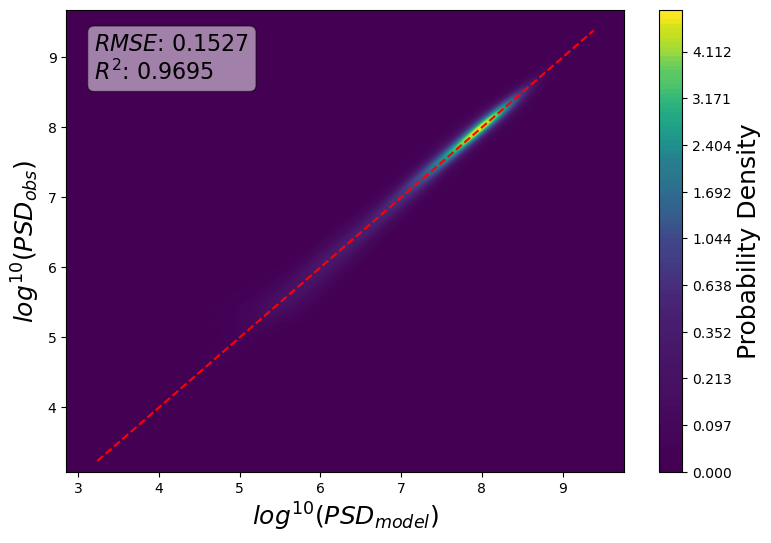

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_squared_error, r2_score
import seaborn as sns

# 显示负号
plt.rcParams['axes.unicode_minus'] = False


y_pred_scaled = model.predict([X_time_val, X_non_time_val])

# 反缩放预测结果
y_pred = scaler_target.inverse_transform(y_pred_scaled)
y_test_subset = scaler_target.inverse_transform(y_val)
y_test_exp = y_test_subset.flatten()
y_pred_exp = y_pred.flatten()
# 计算均方根误差（RMSE）
rmse = np.sqrt(mean_squared_error(y_test_exp, y_pred_exp))
r2 = r2_score(y_test_subset, y_pred)
print(f'测试集上的 RMSE: {rmse}',f'测试集上的 R2: {r2}')
plt.figure(figsize=(9, 6))

# 使用 Seaborn 的 kdeplot 绘制联合概率密度图
ax = sns.kdeplot(
    x=y_test_exp, 
    y=y_pred_exp, 
    cmap='viridis', 
    fill=True, 
    thresh=0, 
    levels=100,
    bw_adjust=1
)

# 添加理想拟合线
plt.plot(
    [y_test_exp.min(), y_test_exp.max()], 
    [y_test_exp.min(), y_test_exp.max()], 
    'r--', 
    label='理想拟合线'
)

# 提取绘图的颜色集合（PolyCollection）
collections = ax.collections

if collections:
    # 创建颜色条，基于第一个集合（KDE 图）
    cbar = plt.colorbar(collections[0], ax=ax)
    cbar.set_label('Probability Density',fontsize=18)

ax.text(
    0.05, 0.95, 
    f'$RMSE$: {rmse:.4f}\n$R^2$: {r2:.4f}', 
    transform=ax.transAxes,
    fontsize=16,
    verticalalignment='top',
    bbox=dict(boxstyle='round', facecolor='white', alpha=0.5)
)
# plt.xlim(-8, -4)
# plt.ylim(-8, -4)
# # 添加图例
# plt.legend()

# 设置坐标轴标签和标题
plt.xlabel('$log^{10}(PSD_{model})$',fontsize=18)
plt.ylabel('$log^{10}(PSD_{obs})$',fontsize=18)
# plt.title('真实值与预测值的概率密度图')

# 显示图形
plt.show()

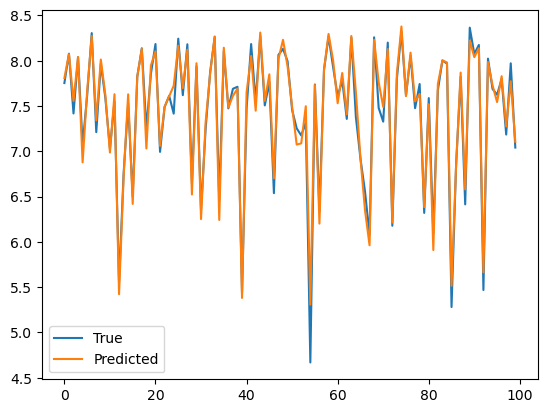

In [43]:
plt.plot(y_test_exp[:100], label='True')
plt.plot(y_pred_exp[:100], label='Predicted')
plt.legend()